In [90]:
#|hide
#|default_exp index

In [48]:
import os

import kaggle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit

In [47]:
#|export
from fastai.vision.all import *
import gradio as gr

def is_cat(x):
    return x[0].isupper()

In [5]:
kaggle.api.authenticate()

kaggle.api.dataset_download_files(dataset="samuelcortinhas/cats-and-dogs-image-classification", 
                                  path="Data", unzip=True)

In [6]:
# settings for all images
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (9.7, 6.27),
}
sns.set_theme(style="white", palette=None, rc=custom_params)
sns.set_context("notebook", font_scale=1.0)

In [7]:
# Path to train images
train_cat_path = "Data/train/cats/"
train_dog_path = "Data/train/dogs/"
train_images_path = {"cat": train_cat_path, "dog": train_dog_path}

# Path to test images
test_cat_path = "Data/test/cats/"
test_dog_path = "Data/test/dogs/"
test_images_path = {"cat": test_cat_path, "dog": test_dog_path}

In [8]:
def populate_dataframe(filepaths: dict) -> pd.DataFrame:
    """
    Parameters:
    filepaths (dict): dictionary of filepaths to populate the dataframe with (label: filepath)
    Returns:
    dataframe (pd.DataFrame): populated dataframe
    """
    data = {"filepath": [], "label": []}  # Where to hold image information

    for label, path in filepaths.items():
        for filename in os.listdir(path):
            if (
                filename.endswith(".jpeg")
                or filename.endswith(".jpg")
                or filename.endswith(".png")
            ):
                # Check for valide image extension
                fullpath = os.path.join(path, filename)  # get full path of image
                data["filepath"].append(fullpath)
                data["label"].append(label)
    dataframe = pd.DataFrame(data)  # populate dataframe
    return dataframe

In [9]:
train_df = populate_dataframe(train_images_path)
test_df = populate_dataframe(test_images_path)

# Well randomly select the validation set
# We'll also sample the test set
# So for now lets combine the test_df with the train_df
df = pd.concat([train_df, test_df])

In [10]:
len(df)

697

In [11]:
# Dataset is too large and will take too long to train

# Create instance of StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(
    n_splits=1, train_size=200, test_size=50, random_state=42
)

# Split the data into training and test sets using the splitter
for train_index, test_index in splitter.split(df["filepath"], df["label"]):
    # train_index and test_index are the indices of the selected samples

    # Create the training and test sets based on the selected indices
    train_samples = df.iloc[train_index]
    test_samples = df.iloc[test_index]  # We'll use this instead of test_df

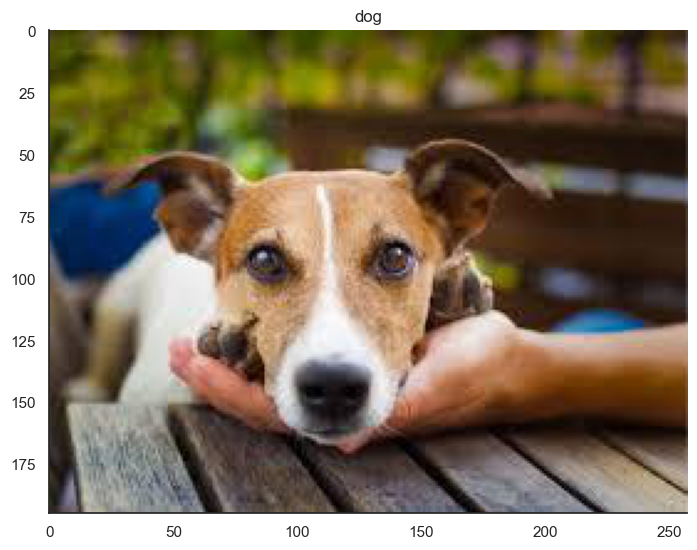

In [12]:
# View image
img = mpimg.imread(test_samples.iloc[0]["filepath"])
plt.imshow(img)
plt.title(test_samples.iloc[0]["label"])
plt.show()

In [14]:
# Define the target column (replace with your actual target column name)
target_col = "label"

# Create and train the DummyClassifier
model = DummyClassifier(strategy="most_frequent")
model.fit(train_samples.drop(columns=[target_col]), train_samples[target_col])

# Make predictions
predicted_labels = model.predict(train_samples.drop(columns=[target_col]))

# Calculate f1_score
actual_labels = train_samples[target_col].tolist()
score = f1_score(
    actual_labels, predicted_labels, average="macro"
)  # Use 'macro' for categorical labels

# Print the predicted label, and recall
print(f"Predicted Label: {model.classes_[0]}")
print(f"F1score: {score:.2f}")

Predicted Label: cat
F1score: 0.33


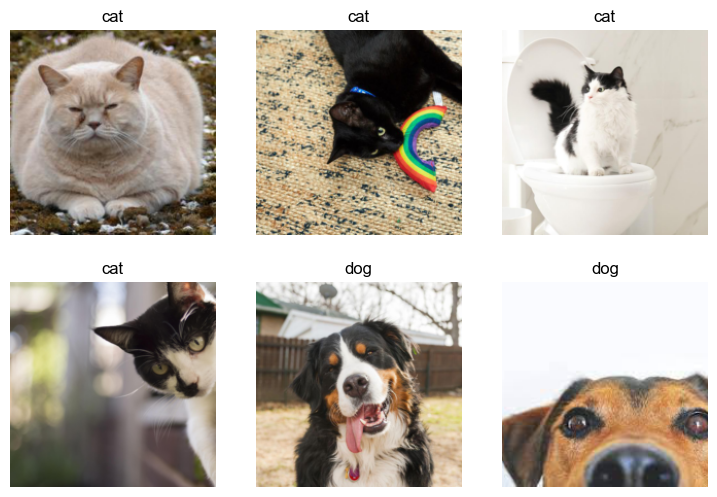

In [18]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader("filepath"),
    get_y=ColReader("label"),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(200),
)

dls = dblock.dataloaders(train_samples)

dls.show_batch(max_n=6)

In [19]:
learn = vision_learner(dls, resnet34, metrics=F1Score(average="macro"))
epochs = 5
learn.fine_tune(epochs)

c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,f1_score,time
0,1.081606,0.454928,0.750000,00:32


epoch,train_loss,valid_loss,f1_score,time
0,0.495862,0.218054,0.899749,00:37
1,0.338633,0.121800,0.949875,00:36
2,0.251134,0.053211,1.000000,00:36
3,0.197069,0.034387,1.000000,00:38
4,0.158712,0.034000,1.000000,00:40


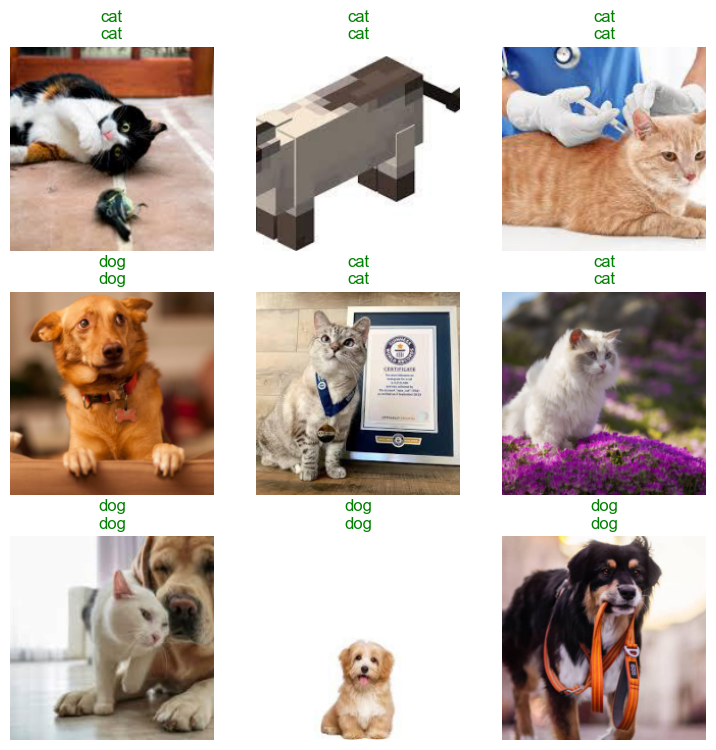

In [20]:
learn.show_results()

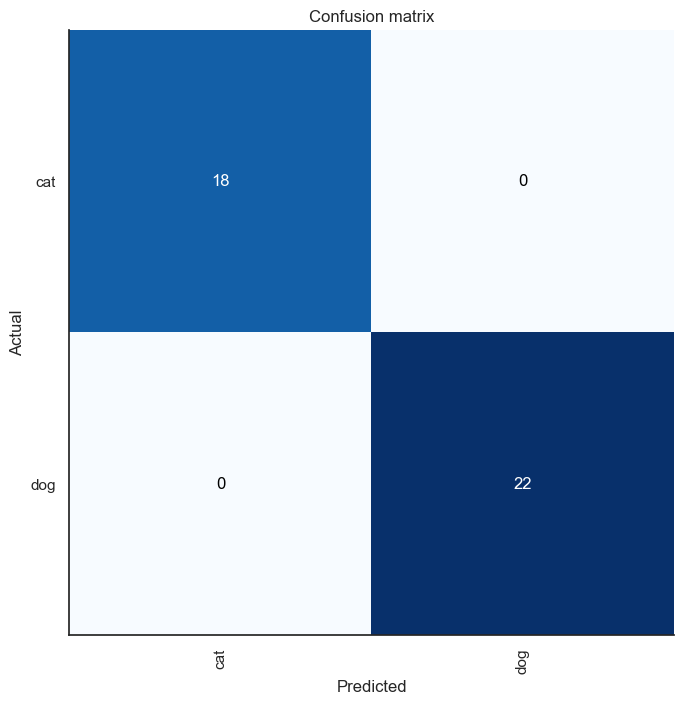

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7, 7));  # The matrix uses the validation data

In [30]:
learn.export()

In [31]:
path = Path()
path.ls(file_exts=['.pkl'])

(#1) [Path('export.pkl')]

In [32]:
#|export
learn_inf = load_learner(path/'export.pkl')

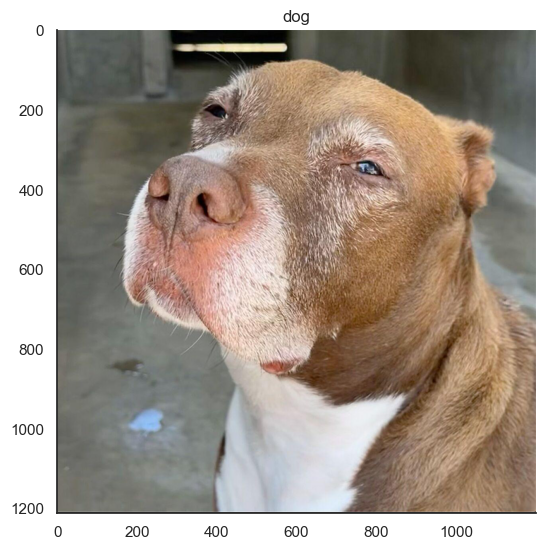

In [37]:
# View image
test_image = test_samples.sample(1)
img = mpimg.imread(test_image.iloc[0]["filepath"])
plt.imshow(img)
plt.title(test_image.iloc[0]["label"])
plt.show()

In [38]:
learn_inf.predict(test_image.iloc[0]['filepath'])

('dog', tensor(1), tensor([3.6239e-04, 9.9964e-01]))

In [39]:
#|export
categories = ('cat', 'dog')

def classify_image(img):
    pred, _, probs = learn_inf.predict(img)
    return dict(zip(categories, map(float, probs)))

In [40]:
classify_image(test_image.iloc[0]['filepath'])

{'cat': 0.0003623896336648613, 'dog': 0.9996376037597656}

In [ ]:
#|export
image = gr.inputs.Image(shape=(512, 512))
label = gr.outputs.Label()
examples = ['data/test/cats/cat_124.jpg', 'data/test/dogs/dog_177.jpg']

intf = gr.Interface(fn=classify_image,
                    inputs=image,
                    outputs=label,
                    examples=examples)
intf.launch(inline=False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2036\307424548.py:2: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(512, 512))
C:\Users\Admin\AppData\Local\Temp\ipykernel_2036\307424548.py:2: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(512, 512))
C:\Users\Admin\AppData\Local\Temp\ipykernel_2036\307424548.py:3: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2036\307424548.py:3: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label()


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


## Export--

In [88]:
from nbdev.migrate import migrate_nb

migrate_nb(path='index.ipynb');

In [91]:
from nbdev.export import nb_export

nbname = 'index.ipynb'
nb_export(nbname=nbname, lib_path='')

In [76]:
help(nb_export)

Help on function nb_export in module nbdev.export:

nb_export(nbname, lib_path=None, procs=<function black_format at 0x000001561DB38F70>, debug=False, mod_maker=<class 'nbdev.maker.ModuleMaker'>, name=None)
    Create module(s) from notebook

